In [1]:
#Import neccessary libraries
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
import numpy as np

SEED = 1213

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
# Data transforms for training and testing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# Paths to your custom dataset
train_data_dir = 'Dataset_split/train'
test_data_dir = 'Dataset_split/test'

# Create ImageFolder datasets for training and testing
train_dataset = datasets.ImageFolder(train_data_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_data_dir, transform=test_transforms)

In [4]:
# Create data loaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


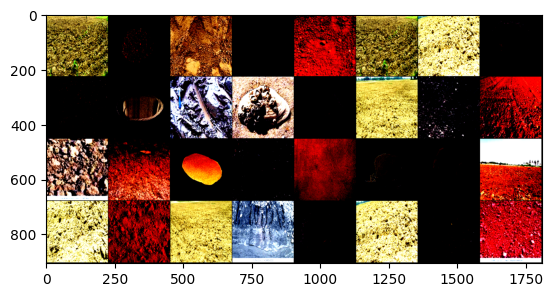

In [5]:
# Visualize the dataset
for img,label in train_loader:
    g = img
    break

grid = make_grid(g)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(grid.permute(1,2,0))

In [6]:
# Load the pre-trained ResNet-50 model
resnet50_model = models.resnet50(pretrained=True)
num_classes = len(train_dataset.classes)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)

C:\Users\rwama\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rwama\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Print model summary
summary(resnet50_model, (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [8]:
# Define a loss function and the Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# Testing the model
def test_model(model,loader,device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [11]:
# Training loop
# Do not run this cell if you just want to test the pretrained model
num_epochs = 20
resnet50_model.to(device)
temp_acc = [0]
for epoch in range(num_epochs):
    resnet50_model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    test_acc = test_model(resnet50_model,test_loader,device)
    if (test_acc >= max(temp_acc)):
        #save model with best test accuracy
        torch.save(resnet50_model.state_dict(), 'custom_resnet50_na.pth')
    temp_acc.append(test_acc)
    print(f"Epoch {epoch + 1}/{num_epochs} Loss: {loss.item()} Test acc: {test_acc}")

print("Training complete")


Epoch 1/20 Loss: 0.3540884852409363 Test acc: 86.41114982578397
Epoch 2/20 Loss: 0.5614991784095764 Test acc: 71.42857142857143
Epoch 3/20 Loss: 0.37634095549583435 Test acc: 85.71428571428571
Epoch 4/20 Loss: 0.43611836433410645 Test acc: 77.70034843205575
Epoch 5/20 Loss: 0.4078098237514496 Test acc: 90.94076655052265
Epoch 6/20 Loss: 0.18289941549301147 Test acc: 94.77351916376307
Epoch 7/20 Loss: 0.034622322767972946 Test acc: 95.1219512195122
Epoch 8/20 Loss: 0.7279216647148132 Test acc: 95.1219512195122
Epoch 9/20 Loss: 0.7785015106201172 Test acc: 95.1219512195122
Epoch 10/20 Loss: 0.42804643511772156 Test acc: 82.57839721254355
Epoch 11/20 Loss: 0.02982572466135025 Test acc: 98.25783972125436
Epoch 12/20 Loss: 0.24535708129405975 Test acc: 92.6829268292683
Epoch 13/20 Loss: 0.13702945411205292 Test acc: 96.86411149825784
Epoch 14/20 Loss: 0.5419268012046814 Test acc: 95.81881533101046
Epoch 15/20 Loss: 0.3093702793121338 Test acc: 96.16724738675958
Epoch 16/20 Loss: 0.119458675

In [12]:
print(f"Best test accuracy: {max(temp_acc)}")

Best test accuracy: 98.25783972125436


In [13]:
import time
from PIL import Image
import torchvision.transforms as transforms

# Define a function for inference
def predict_custom_image(image_path, model, device):

    # Load the image and apply the same transformations used during training
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add a batch dimension

    # Move the image to the same device as the model (CPU or GPU)
    image = image.to(device)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_index = predicted.item()
        class_name = train_dataset.classes[class_index]
    
    return class_name



In [14]:
# Usage
custom_image_path = "Dataset_split/test/Clay soil/images22.jpg"
predicted_class = predict_custom_image(custom_image_path, resnet50_model, device)
print(f"The model predicts that the image belongs to class: {predicted_class}")

The model predicts that the image belongs to class: Clay soil


In [15]:
# Load saved model
saved_model = models.resnet50(pretrained=True)
num_classes = len(train_dataset.classes)
saved_model.fc = nn.Linear(saved_model.fc.in_features, num_classes)

saved_model.load_state_dict(torch.load('custom_resnet50_na.pth'))
saved_model = saved_model.to(device)

In [16]:
print(f"Test Accuracy: {test_model(saved_model,test_loader,device)}%")

Test Accuracy: 98.25783972125436%


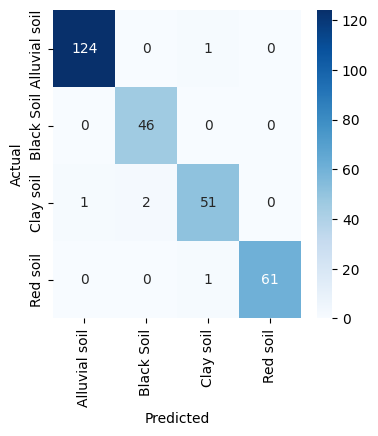

In [17]:
def create_confusion_matrix(model, test_loader, num_classes):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=list(range(num_classes)))
    clsreport = classification_report(all_labels, all_predictions)
    return cm, clsreport

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

num_classes = len(test_dataset.classes)
confusion_matrix_result, clsreport = create_confusion_matrix(saved_model, test_loader, num_classes)
class_names = test_loader.dataset.classes

plot_confusion_matrix(confusion_matrix_result, class_names)


In [18]:
print(clsreport)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       125
           1       0.96      1.00      0.98        46
           2       0.96      0.94      0.95        54
           3       1.00      0.98      0.99        62

    accuracy                           0.98       287
   macro avg       0.98      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287



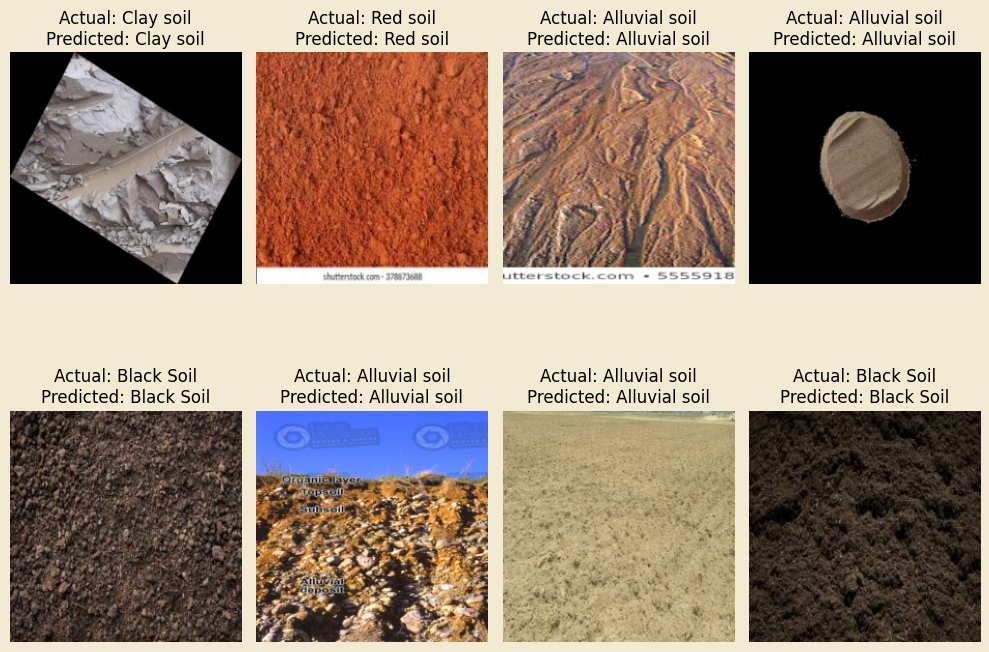

In [19]:

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    # Clone the input tensor to avoid modifying the original tensor
    denormalized = tensor.clone()

    # Loop through each channel and apply denormalization
    for i in range(denormalized.size(0)):  # Iterate over channels
        denormalized[i, :, :] = denormalized[i, :, :] * std[i] + mean[i]

    return denormalized
    
# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = denormalize(tensor)
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = np.transpose(image, (1, 2, 0))
    # image = np.clip(image, 0, 1)  # Clip values to be in the range [0, 1]
    return image

# Function to display images with labels
def display_images(images, actual_labels, predicted_labels):
    fig, axes = plt.subplots(2, 4, figsize=(10, 8))
    axes = axes.flatten()
    for i, (image, actual, predicted) in enumerate(zip(images, actual_labels, predicted_labels)):
        axes[i].imshow(image)
        axes[i].set_title(f"Actual: {actual}\nPredicted: {predicted}")
        axes[i].axis('off')

    fig.patch.set_facecolor('#f2ead3')
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Choose 4 random images from the test set
selected_images = []
actual_labels = []
predicted_labels = []

for _ in range(8):
    data = next(iter(test_loader))
    image, actual_label = data[0][0].to(device), data[1][0]
    selected_images.append(tensor_to_image(image))
    actual_labels.append(test_loader.dataset.classes[actual_label])

    # Make prediction
    with torch.no_grad():
        output = saved_model(image.unsqueeze(0))
        _, predicted_label = torch.max(output.data, 1)
        predicted_labels.append(test_loader.dataset.classes[predicted_label.item()])

# Display the image grid
display_images(selected_images, actual_labels, predicted_labels)
